In [1]:
from google.colab import drive
drive.mount('/content/drive')  #listになかったのでドライブ上にデータ保存し、ドライブをマウント。

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/signate/モジュール系/EDA')
sys.path.append('/content/drive/MyDrive/signate/モジュール系/Feature Engineering')
sys.path.append('/content/drive/MyDrive/signate/モジュール系/meanF1')

In [3]:
### 自作モジュール
from plot_qq_plots import plot_qq_plots
from reduce_mem import reduce_mem_usage
from show_corr import show_corr
from target_encoded import get_kfold, get_targetencoding, to_target
from obj_to_cat import to_cat_data
from normalize_col import normalize_columns
from combined_features import create_combined_features
from threshold_tuning_binary import threshold_tuning_binary

In [4]:
### その他
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
pd.set_option('display.max_columns', None)

EDAファイル読み込み

In [6]:
EDA_train = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/途中経過_csv/EDA_train")
EDA_test = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/途中経過_csv/EDA_test")

In [7]:
# 確認
display(EDA_train.head())
display(EDA_test.head())

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0
1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0
2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1
3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33,2003-10-06,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0
4,184,0,1.0,0,0,0,N,N,1983-06-08,1,0,1999-12-17,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0


,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,5,2,1.0,1,0,0,T,N,2004-07-31,23,2007-08-06,2007,SUNNYVALE,CA,CA,25000.0,25000.0,21250.0,1
1,235,13,1.0,9,14,77725,Y,N,1995-01-11,44,2004-03-08,2004,PITTSBURGH,PA,PA,15000.0,15000.0,7500.0,0
2,31,5,2.0,0,0,0,N,NaN,NaN,56,2007-02-27,2007,LITTLE ROCK,AR,AR,28000.0,28000.0,23800.0,1
3,120,4,1.0,0,1,0,Y,N,1999-04-30,62,1997-12-19,1998,LITTLE ROCK,AR,AR,7500.0,7500.0,6375.0,2
4,63,13,1.0,0,8,1,N,N,2005-12-31,42,2009-07-10,2009,Louisville,KY,DE,91000.0,93000.0,93000.0,0


# **特徴量エンジニアリング**

標準化関数

In [8]:
# 標準化
from sklearn.preprocessing import StandardScaler
def scale_timestamps(df, columns):
    scaler = StandardScaler()
    for col in columns:
        # DataFrameのカラムを適切にリシェイプしてスケーリングを適用
        scaled_data = scaler.fit_transform(df[[col]])

        # スケーリングされたデータを上書き
        df[col] = scaled_data

    return df

In [9]:
eng_train = EDA_train.copy()
eng_test = EDA_test.copy()

### US Cityデータ追加,州データと結合 pop dens

In [10]:
# train, testのcityカラムを整える
eng_train.rename(columns = {"City":"city"}, inplace=True)
eng_test.rename(columns = {"City":"city"}, inplace=True)
eng_train["city"] = eng_train["city"].str.upper().str.replace(' ', '').str.strip()
eng_test["city"] = eng_test["city"].str.upper().str.replace(' ', '').str.strip()

In [11]:
uscity = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/uscities.csv")
uscity = uscity[["city", "state_id", "state_name", "population", "density", "county_fips"]]
# 浮動小数を丸める
uscity["county_fips"] = uscity["county_fips"].round(decimals=0)

# city列を整える
uscity["city"] = uscity["city"].str.upper().str.replace(' ', '').str.strip()
uscity["state_name"] = uscity["state_name"].str.upper().str.replace(' ', '').str.strip()

#不要カラム削除
uscity = uscity.drop(["state_id", "state_name"], axis=1)
uscity = uscity.drop_duplicates(subset=["city"])  #ユニーク値だけ
#結合
eng_train = pd.merge(eng_train, uscity, on="city", how='left') #left結合
eng_test = pd.merge(eng_test, uscity, on="city", how='left') #left結合
eng_train

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips
0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,4064275.0,1198.9,4013.0
1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,18110.0,392.8,40121.0
2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,86978.0,5516.7,6037.0
3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33,2003-10-06,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,1177657.0,555.4,47037.0
4,184,0,1.0,0,0,0,N,N,1983-06-08,1,0,1999-12-17,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,149831.0,2516.9,6037.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,283,14,1.0,0,0,1,N,N,1998-01-31,1,0,1995-03-02,1995,PHILADELPHIA,PA,PA,80000.0,80000.0,68000.0,0,5683533.0,4578.4,42101.0
42303,53,2,1.0,0,0,0,Y,N,1991-04-03,1,42,2007-06-06,2007,LOSANGELES,CA,SD,5000.0,5000.0,4250.0,1,11922389.0,3184.7,6037.0
42304,59,6,2.0,0,0,1,N,N,2003-02-28,1,42,2003-03-14,2003,COLUMBUS,OH,OH,60000.0,60000.0,51000.0,0,1572546.0,1581.0,39049.0
42305,295,18,1.0,0,8,0,N,N,1997-12-10,1,42,1989-08-23,1989,CLOQUET,MN,MN,294000.0,294000.0,220500.0,0,12559.0,137.7,27017.0


In [12]:
col = ["population", "density"]
eng_train = scale_timestamps(eng_train, col)
eng_test = scale_timestamps(eng_test, col)

### 群 county_fips

In [13]:
ua_county = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/ua_county.csv")
ua_county = reduce_mem_usage(ua_county)

ua_county = ua_county[["STATE","COUNTY","POP_COU","HOU_COU","ALAND_COU","TOTALBLOCKS","COUNTY_NAME",
                       "ALAND_PCT_URB","URBANBLOCKS","HOUPCT_RUR","ALAND_RUR","ALAND_PCT_RUR",
                       "POPDEN_RUR","HOUDEN_RUR","RURALBLOCKS"]]
# strにする
ua_county["STATE"] = ua_county["STATE"].astype(str)
ua_county["COUNTY"] = ua_county["COUNTY"].astype(str)
# 整える
ua_county["STATE"] = ua_county["STATE"].str.upper().str.replace(' ', '').str.strip()
ua_county["COUNTY"] = ua_county["COUNTY"].str.upper().str.replace(' ', '').str.strip()
ua_county["COUNTY"] = ua_county["COUNTY"].astype(str).str.zfill(3) #countyだけ3桁0で埋める

ua_county["county_fips"] = ua_county["STATE"]+ua_county["COUNTY"]
ua_county["county_fips"] = ua_county["county_fips"].astype(float).round(decimals=0)

ua_county = ua_county.drop(["STATE","COUNTY"],axis=1)

#URBANBLOCKS/TOTALBLOCKSとRURALBLOCKS/TOTALBLOCKSを用意
ua_county["URB_pct"] = ua_county["URBANBLOCKS"] / (ua_county["TOTALBLOCKS"] + 1e-8)
ua_county["RUR_pct"] = ua_county["RURALBLOCKS"] / (ua_county["TOTALBLOCKS"] + 1e-8)

#後で使う
ua_countys = ua_county.copy()

# いくつ共通しているか確認
a = eng_train["county_fips"].isin(ua_county["county_fips"])
print(a.sum())

Memory usage of dataframe is 0.76 MB
Memory usage after optimization is: 0.35 MB
Decreased by 53.6%
40511


In [14]:
ua_county.head()

,POP_COU,HOU_COU,ALAND_COU,TOTALBLOCKS,COUNTY_NAME,ALAND_PCT_URB,URBANBLOCKS,HOUPCT_RUR,ALAND_RUR,ALAND_PCT_RUR,POPDEN_RUR,HOUDEN_RUR,RURALBLOCKS,county_fips,URB_pct,RUR_pct
0,58805,24350,1539634184,1512,Autauga,0.036316,521,0.410400,1483727020,0.963867,41.750000,17.437500,991,1001.0,0.344577,0.655423
1,231767,124148,4117656199,6337,Baldwin,0.086243,3156,0.328125,3762600021,0.913574,59.968750,28.046875,3181,1003.0,0.498027,0.501973
2,25223,11618,2292160149,1283,Barbour,0.007038,272,0.648926,2276027730,0.993164,18.921875,8.578125,1011,1005.0,0.212003,0.787997
3,22293,9002,1612188717,1090,Bibb,0.000000,0,1.000000,1612188717,1.000000,35.812500,14.460938,1090,1007.0,0.000000,1.000000
4,59134,24622,1670259090,2404,Blount,0.006783,197,0.907227,1658933117,0.993164,83.562500,34.875000,2207,1009.0,0.081947,0.918053


In [15]:
### 多重共線性の削除
numeric_cols = ua_county.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop(["county_fips"])

# 相関行列を計算し、高い相関のペアを見つける関数
def find_high_corr_pairs(df, threshold=0.95):
    corr_matrix = df.corr()
    high_corr_pairs = []
    for i, col1 in enumerate(corr_matrix.columns):
        for j, col2 in enumerate(corr_matrix.index):
            if i < j and abs(corr_matrix[col1][col2]) > threshold:
                high_corr_pairs.append((col1, col2))
    return high_corr_pairs

# 最初の相関係数が高いカラムペアを見つける
high_corr_pairs = find_high_corr_pairs(ua_county)
del_col = [pair[0] for pair in high_corr_pairs]  # ここでは例として最初のカラムを削除リストに追加
# 削除リストに含まれるカラムをDataFrameから実際に削除
ua_county = ua_county.drop(columns=del_col)

# 削除リストに含まれるカラムを表示
print("削除するカラム:", del_col)

削除するカラム: ['POP_COU', 'HOU_COU', 'ALAND_COU', 'TOTALBLOCKS', 'ALAND_PCT_URB', 'URB_pct']


<ipython-input-15-87603476e774>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [16]:
# 田舎との相関を見る
# 相関を見た結果["HOUPCT_RUR","ALAND_PCT_RUR","RUR_pct"]のみ結合
ua_county = ua_county["county_fips"] #効果なかったので削除"HOUPCT_RUR","ALAND_PCT_RUR","RUR_pct"

In [17]:
#結合
eng_train = pd.merge(eng_train, ua_county, on="county_fips", how='left') #left結合
eng_test = pd.merge(eng_test, ua_county, on="county_fips", how='left') #left結合
"""
# 標準化
col = ua_county.columns
col = col.drop(["county_fips"])
eng_train = scale_timestamps(eng_train, col)
eng_test = scale_timestamps(eng_test, col)
"""
eng_train.head()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips
0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,0.946886,-0.262742,4013.0
1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,-0.497361,-0.607594,40121.0
2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,-0.472779,1.584427,6037.0
3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33,2003-10-06,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,-0.083470,-0.538033,47037.0
4,184,0,1.0,0,0,0,N,N,1983-06-08,1,0,1999-12-17,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,-0.450345,0.301103,6037.0


In [18]:
eng_train["city"].nunique()

2497

In [19]:
"""
## 田舎との相関を見る
col = fin_train.select_dtypes(include="number").columns

show_corr(fin_train, col)
"""

'\n## 田舎との相関を見る\ncol = fin_train.select_dtypes(include="number").columns\n\nshow_corr(fin_train, col)\n'

### cityとTerm

In [20]:
agg_cols = ['mean']

cat_cols=["city"]

for col in cat_cols:
    grp_df = eng_train.groupby(col)["Term"].agg(agg_cols)
    grp_df.columns = [f'{col}_Term_{c}' for c in agg_cols]
    eng_train = eng_train.merge(grp_df, on=col, how='left')
    eng_test = eng_test.merge(grp_df, on=col, how='left')

for col in cat_cols:
    grp_df = eng_train.groupby(col)["NoEmp"].agg(agg_cols)
    grp_df.columns = [f'{col}_NoEmp_{c}' for c in agg_cols]
    eng_train = eng_train.merge(grp_df, on=col, how='left')
    eng_test = eng_test.merge(grp_df, on=col, how='left')

In [21]:
col = ["city_Term_mean","city_NoEmp_mean"]
eng_train = scale_timestamps(eng_train, col)
eng_test = scale_timestamps(eng_test, col)
eng_train

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips,city_Term_mean,city_NoEmp_mean
0,163,21,1.0,0,0,1,N,N,1998-01-31,1,0,2006-09-22,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,0.946886,-0.262742,4013.0,0.340674,0.025567
1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62,1992-06-30,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,-0.497361,-0.607594,40121.0,0.278514,0.602236
2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,-0.472779,1.584427,6037.0,1.431541,1.924813
3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33,2003-10-06,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,-0.083470,-0.538033,47037.0,0.656550,0.312064
4,184,0,1.0,0,0,0,N,N,1983-06-08,1,0,1999-12-17,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,-0.450345,0.301103,6037.0,-0.353252,-0.733481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,283,14,1.0,0,0,1,N,N,1998-01-31,1,0,1995-03-02,1995,PHILADELPHIA,PA,PA,80000.0,80000.0,68000.0,0,1.524868,1.183019,42101.0,0.723010,-0.127232
42303,53,2,1.0,0,0,0,Y,N,1991-04-03,1,42,2007-06-06,2007,LOSANGELES,CA,SD,5000.0,5000.0,4250.0,1,3.751780,0.586790,6037.0,-0.823782,-0.822185
42304,59,6,2.0,0,0,1,N,N,2003-02-28,1,42,2003-03-14,2003,COLUMBUS,OH,OH,60000.0,60000.0,51000.0,0,0.057483,-0.099278,39049.0,0.008539,-0.319465
42305,295,18,1.0,0,8,0,N,N,1997-12-10,1,42,1989-08-23,1989,CLOQUET,MN,MN,294000.0,294000.0,220500.0,0,-0.499343,-0.716727,27017.0,4.195320,0.789554


### セクターの0をnanにする

In [22]:
# 0をnanにする
def sector_nan(df):
  df["Sector"] = df["Sector"].astype(float)
  df['Sector'] = df['Sector'].replace(0, np.nan)
  return df

eng_train = sector_nan(eng_train)
eng_test = sector_nan(eng_test)

### **銀行によって支払われた金額 - SBAが保証する承認されたローンの金額**

In [23]:
# SBA_Appv SBAが保証する承認されたローンの金額
# DisbursementGross 銀行によって支払われた金額
"""
# 差だけ取る
eng_train["DisbursementGross_minus_SBA_Appv"] = eng_train["DisbursementGross"] - eng_train["SBA_Appv"]
eng_test["DisbursementGross_minus_SBA_Appv"] = eng_test["DisbursementGross"]  - eng_test["SBA_Appv"]
col=["DisbursementGross_minus_SBA_Appv"]

"""
### create_combine関数で新しい特徴量をつくる
eng_train = create_combined_features(eng_train, "DisbursementGross", "SBA_Appv")
eng_test = create_combined_features(eng_test, "DisbursementGross", "SBA_Appv")

col=['DisbursementGross_plus_SBA_Appv',
       'DisbursementGross_minus_SBA_Appv', 'DisbursementGross_times_SBA_Appv',
       'DisbursementGross_divided_by_SBA_Appv']


eng_train = scale_timestamps(eng_train, col)
eng_test = scale_timestamps(eng_test, col)


### **SBAが保証する承認されたローンの金額/銀行によって承認されたローンの総額**

In [24]:
"""
## 比率だけをとる
eng_train["SBA_Appv_by_GrAppv"] = eng_train["SBA_Appv"] /(eng_train["GrAppv"] + 1e-8)
eng_test["SBA_Appv_by_GrAppv"] = eng_test["SBA_Appv"] /(eng_test["GrAppv"] + 1e-8)
"""

#GrAppv 銀行によって承認されたローンの総額
eng_train = create_combined_features(eng_train, "SBA_Appv", "GrAppv")
eng_test = create_combined_features(eng_test, "SBA_Appv", "GrAppv")

col=['SBA_Appv_plus_GrAppv',
       'SBA_Appv_minus_GrAppv', 'SBA_Appv_times_GrAppv',
       'SBA_Appv_divided_by_GrAppv']
eng_train = scale_timestamps(eng_train, col)
eng_test = scale_timestamps(eng_test, col)


### **銀行によって支払われた金額/銀行によって承認されたローンの総額**

In [25]:
"""
## 比率だけをとる
eng_train["DisbursementGross_by_GrAppv"] = eng_train["DisbursementGross"] /(eng_train["GrAppv"] + 1e-8)
eng_test["DisbursementGross_by_GrAppv"] = eng_test["DisbursementGross"] /(eng_test["GrAppv"] + 1e-8)
"""
eng_train = create_combined_features(eng_train, "DisbursementGross", "GrAppv")
eng_test = create_combined_features(eng_test, "DisbursementGross", "GrAppv")

col=['DisbursementGross_plus_GrAppv',
       'DisbursementGross_minus_GrAppv', 'DisbursementGross_times_GrAppv',
       'DisbursementGross_divided_by_GrAppv']
eng_train = scale_timestamps(eng_train, col)
eng_test = scale_timestamps(eng_test, col)


### **年別の景気を数値で表す**

***その企業の融資を受けていた期間のカラムを追加***

In [26]:
# DisbursementDate(融資開始日)からTerm(返済日までの月数)を足す
eng_train['DisbursementDate'] = pd.to_datetime(eng_train['DisbursementDate'])
eng_test['DisbursementDate'] = pd.to_datetime(eng_test['DisbursementDate'])

eng_train['LoanEnd'] = eng_train.apply(lambda x: x['DisbursementDate'] + pd.DateOffset(months=x['Term']), axis=1)
eng_test['LoanEnd'] = eng_test.apply(lambda x: x['DisbursementDate'] + pd.DateOffset(months=x['Term']), axis=1)

In [27]:
eng_train[['DisbursementDate','Term','LoanEnd']]

,DisbursementDate,Term,LoanEnd
0,1998-01-31,163,2011-08-31
1,1993-10-31,84,2000-10-31
2,2001-08-31,242,2021-10-31
3,2007-08-31,237,2027-05-31
4,1983-06-08,184,1998-10-08
...,...,...,...
42302,1998-01-31,283,2021-08-31
42303,1991-04-03,53,1995-09-03
42304,2003-02-28,59,2008-01-28
42305,1997-12-10,295,2022-07-10


In [28]:
### データ内最初の年
a = pd.to_datetime(eng_test['ApprovalDate']).min()
b = pd.to_datetime(eng_test['DisbursementDate']).min()
print(a,b)

1973-10-17 00:00:00 1973-12-06 00:00:00


### PPI(生産者物価指数)からデフレ時期を見る。

In [29]:
### PPI(生産者物価指数)からデフレ時期を見る。
PPI = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/PPI.csv")
PPI['DATE'] = pd.to_datetime(PPI['DATE'])

# 1970年以降のデータに分割
PPI = PPI[PPI['DATE'].dt.year >= 1970]

# 'Quarter'カラムを追加
PPI['Quarter'] = PPI['DATE'].dt.to_period('Q')

# 4半期ごとの平均値
PPI['Quarterly_Avg_PPIACO'] = PPI.groupby("Quarter")["PPIACO"].transform('mean')

# 'column_name'のユニークな値のみを保持する
PPI = PPI.drop_duplicates(subset='Quarter', keep='first')

# 結果の確認
PPI["lr"] = PPI["Quarterly_Avg_PPIACO"].pct_change().fillna(method='bfill')

PPI

,DATE,PPIACO,Quarter,Quarterly_Avg_PPIACO,lr
684,1970-01-01,36.500,1970Q1,36.633333,0.005460
687,1970-04-01,36.800,1970Q2,36.833333,0.005460
690,1970-07-01,37.100,1970Q3,37.033333,0.005430
693,1970-10-01,37.100,1970Q4,37.100000,0.001800
696,1971-01-01,37.300,1971Q1,37.600000,0.013477
...,...,...,...,...,...
1317,2022-10-01,265.061,2022Q4,262.038333,-0.029150
1320,2023-01-01,260.227,2023Q1,258.652667,-0.012921
1323,2023-04-01,256.908,2023Q2,254.812667,-0.014846
1326,2023-07-01,253.835,2023Q3,256.791333,0.007765


In [30]:
"""
PPI.to_csv("/content/ppi.csv", index=False)
eng_train[['DisbursementDate','Term','LoanEnd']].to_csv("/content/train.csv", index=False)
"""

'\nPPI.to_csv("/content/ppi.csv", index=False)\neng_train[[\'DisbursementDate\',\'Term\',\'LoanEnd\']].to_csv("/content/train.csv", index=False)\n'

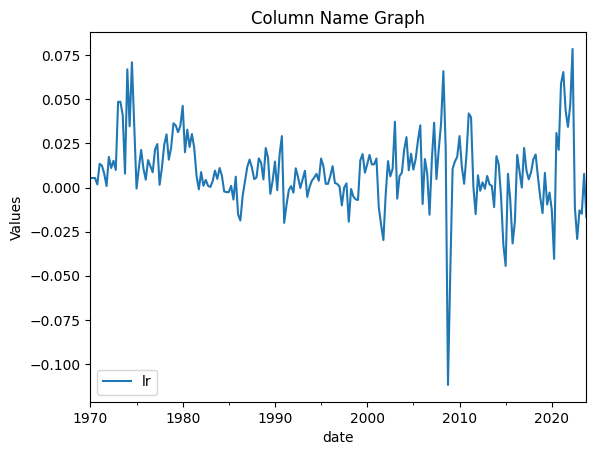

In [31]:
#可視化
PPI.plot(x="DATE", y='lr')

plt.title('Column Name Graph')
plt.xlabel('date')
plt.ylabel('Values')
plt.show()

In [32]:
### DisbursementDateとloan_endの間にあるdateの時のlrをeng_trainに追加
# ppiで各日付のlrの平均値を計算
ppi_lr_avg = PPI.groupby('DATE')['lr'].mean().reset_index()

# trainの新しいカラムlr_avgに条件に合致するppiのlrの平均値を代入
def get_lr_avg(row):
    lr_avg = ppi_lr_avg[(ppi_lr_avg['DATE'] >= row['DisbursementDate']) & (ppi_lr_avg['DATE'] <= row['LoanEnd'])]['lr'].mean()
    return lr_avg

eng_train['lr_avg_ppi'] = eng_train.apply(get_lr_avg, axis=1)
eng_test['lr_avg_ppi'] = eng_test.apply(get_lr_avg, axis=1)

eng_train.head()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips,city_Term_mean,city_NoEmp_mean,DisbursementGross_plus_SBA_Appv,DisbursementGross_minus_SBA_Appv,DisbursementGross_times_SBA_Appv,DisbursementGross_divided_by_SBA_Appv,SBA_Appv_plus_GrAppv,SBA_Appv_minus_GrAppv,SBA_Appv_times_GrAppv,SBA_Appv_divided_by_GrAppv,DisbursementGross_plus_GrAppv,DisbursementGross_minus_GrAppv,DisbursementGross_times_GrAppv,DisbursementGross_divided_by_GrAppv,LoanEnd,lr_avg_ppi
0,163,21,1.0,0,0,1,N,N,1998-01-31,1,NaN,2006-09-22,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,0.946886,-0.262742,4013.0,0.340674,0.025567,-0.376908,-0.348687,-0.241432,-0.421555,-0.362947,0.400124,-0.246556,0.679984,-0.392559,-0.091355,-0.249590,-0.248797,2011-08-31,0.009412
1,84,6,1.0,4,0,0,0,N,1993-10-31,1,62.0,1992-06-30,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,-0.497361,-0.607594,40121.0,0.278514,0.602236,0.445355,0.183318,-0.025699,-0.364422,0.454990,-0.345648,-0.028450,0.380322,0.448131,-0.091355,-0.025346,-0.248797,2000-10-31,0.004728
2,242,45,1.0,4,90,0,N,N,2001-08-31,1,42.0,2001-04-18,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,-0.472779,1.584427,6037.0,1.431541,1.924813,-0.602254,-0.290295,-0.259132,0.321061,-0.591509,0.350844,-0.264559,-1.417653,-0.591597,-0.057794,-0.265649,-0.129082,2021-10-31,0.007699
3,237,4,1.0,0,0,0,N,N,2007-08-31,1,33.0,2003-10-06,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,-0.083470,-0.538033,47037.0,0.656550,0.312064,0.314631,-0.489305,-0.073710,-0.558675,0.324955,0.597244,-0.076989,1.578972,0.212575,-0.091355,-0.113687,-0.248797,2027-05-31,0.006209
4,184,0,1.0,0,0,0,N,N,1983-06-08,1,NaN,1999-12-17,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,-0.450345,0.301103,6037.0,-0.353252,-0.733481,1.342460,1.048705,0.476827,-0.299670,1.347377,-1.558760,0.479606,0.080659,1.414720,-0.091355,0.545105,-0.248797,1998-10-08,0.003334


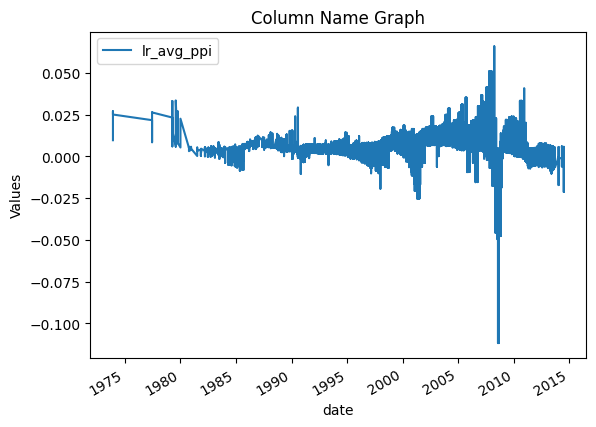

In [33]:
#可視化
eng_train.plot(x="DisbursementDate", y='lr_avg_ppi')

plt.title('Column Name Graph')
plt.xlabel('date')
plt.ylabel('Values')
plt.show()

### isolation forest

In [34]:
train_outlier = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/train_outlier.csv")
test_outlier = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/データセット/test_outlier.csv")

eng_train["outlier"] = train_outlier["outlier_scores"]
eng_test["outlier"] = test_outlier["outlier_scores"]

## datetimeオブジェクトをUNIXタイムスタンプ(float型)に変換する

In [35]:
from datetime import datetime

# datetimeに変換後、UNIXタイムスタンプに変換
def time_stamp(df, col):  # colはリスト["a","b"...]
    for i in col:
        # カラムをdatetimeオブジェクトに変換
        df[i] = pd.to_datetime(df[i], errors='coerce')
        # timestampを計算
        df[f'{i}_timestamp'] = df[i].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
    return df

datetime_col = ["DisbursementDate", "ApprovalDate", "LoanEnd"]
eng_train = time_stamp(eng_train, datetime_col)
eng_test = time_stamp(eng_test, datetime_col)

## 融資の承認と実行の日数差

In [36]:
### SBAの承認が遅い理由に事後承認などがある。（緊急性など）
# 時間に変更
eng_train[['ApprovalDate', 'DisbursementDate']] = eng_train[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)
eng_test[['ApprovalDate', 'DisbursementDate']] = eng_test[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

# 平均を計算、文字列にする
days_mean =str(np.mean(eng_train['DisbursementDate'] - eng_train['ApprovalDate']))
days_mean = days_mean[:days_mean.find("days") + 4]

eng_train['ApprovalToDisbursement_days'] = (eng_train['DisbursementDate'] - eng_train['ApprovalDate']).fillna(days_mean).dt.days.astype(int)
eng_test['ApprovalToDisbursement_days'] = (eng_test['DisbursementDate'] - eng_test['ApprovalDate']).fillna(days_mean).dt.days.astype(int)

col = ["ApprovalToDisbursement_days"]
eng_train = normalize_columns(eng_train, col)
eng_test = normalize_columns(eng_test, col)

# **-------------最終形成--------------**



### カテゴリ変数の定義

In [37]:
fin_train = eng_train.copy()
fin_test = eng_test.copy()

削除

In [38]:
### datetime,county_fips削除
timestamp_col = ["DisbursementDate", "ApprovalDate", "LoanEnd"]
fin_train = fin_train.drop(["DisbursementDate", "ApprovalDate", "LoanEnd"], axis=1)
fin_test = fin_test.drop(["DisbursementDate", "ApprovalDate", "LoanEnd"], axis=1)

カテゴリ変数の抽出

In [39]:
## カテゴリ変数の抽出
cols_notcat = ['MIS_Status', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
               'DisbursementGross', 'GrAppv', 'SBA_Appv','population', 'density',
               'lr_avg_ppi','ApprovalToDisbursement_days','outlier'] # 数値特徴量 'DisbursementGross_minus_SBA_Appv'
# county_col = ['county_gdp','sector_count']
time_col = ["DisbursementDate_timestamp",	"ApprovalDate_timestamp",	"LoanEnd_timestamp"]
dissba = ['DisbursementGross_plus_SBA_Appv','DisbursementGross_minus_SBA_Appv', 'DisbursementGross_times_SBA_Appv','DisbursementGross_divided_by_SBA_Appv']
sbagr = ['SBA_Appv_plus_GrAppv','SBA_Appv_minus_GrAppv', 'SBA_Appv_times_GrAppv','SBA_Appv_divided_by_GrAppv']
disgr = ['DisbursementGross_plus_GrAppv','DisbursementGross_minus_GrAppv', 'DisbursementGross_times_GrAppv','DisbursementGross_divided_by_GrAppv']
# year_col = ["USREC_SUM"]
# urb_col = ["HOUPCT_RUR","ALAND_PCT_RUR","RUR_pct"]
city_col = ["city_Term_mean","city_NoEmp_mean"]

cols_notcat = cols_notcat + city_col + dissba + sbagr + disgr + time_col # 数値特徴量

#------------------------------------------------------------------------------------------


ordinal_cols_cat = [c for c in fin_train.columns if not c in cols_notcat] # カテゴリ特徴量

カテゴリ化(label encode)

In [40]:
### カテゴリ化(label encode)
fin_train = to_cat_data(fin_train, ordinal_cols_cat)  # 数値特徴量以外をすべてカテゴリ化(targetenodingは各モデルで後で適用)
fin_test = to_cat_data(fin_test, ordinal_cols_cat)

FranchiseCode 271
RevLineCr 4
LowDoc 6
Sector 23
ApprovalFY 38
city 2497
State 51
BankState 51
UrbanRural 3
county_fips 1057
FranchiseCode 271
RevLineCr 4
LowDoc 6
Sector 23
ApprovalFY 38
city 2498
State 51
BankState 52
UrbanRural 3
county_fips 1059


標準化

In [43]:
### 標準化関数 columns=["a", "b"....]
from sklearn.preprocessing import StandardScaler

def scale_timestamps(df, columns):
    scaler = StandardScaler()
    for col in columns:
        # DataFrameのカラムを適切にリシェイプしてスケーリングを適用
        scaled_data = scaler.fit_transform(df[[col]])

        # スケーリングされたデータを上書き
        df[col] = scaled_data

    return df

to_std_col = ['DisbursementGross', 'GrAppv', 'SBA_Appv','DisbursementDate_timestamp', 'ApprovalDate_timestamp', 'LoanEnd_timestamp', 'lr_avg_ppi'] # 'lr_avg_ppi', 'lr_avg_rgdp','lr_avg_trea'


# 特定のカラム（この例では'timestamp'）に対してスケーリング関数を適用
fin_train = scale_timestamps(fin_train, to_std_col)
fin_test = scale_timestamps(fin_test, to_std_col)

In [44]:
display(fin_train.head())
display(fin_test.head())

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips,city_Term_mean,city_NoEmp_mean,DisbursementGross_plus_SBA_Appv,DisbursementGross_minus_SBA_Appv,DisbursementGross_times_SBA_Appv,DisbursementGross_divided_by_SBA_Appv,SBA_Appv_plus_GrAppv,SBA_Appv_minus_GrAppv,SBA_Appv_times_GrAppv,SBA_Appv_divided_by_GrAppv,DisbursementGross_plus_GrAppv,DisbursementGross_minus_GrAppv,DisbursementGross_times_GrAppv,DisbursementGross_divided_by_GrAppv,lr_avg_ppi,outlier,DisbursementDate_timestamp,ApprovalDate_timestamp,LoanEnd_timestamp,ApprovalToDisbursement_days
0,163,21,1.0,0,0,1,1,3,1,23,29,1724,3,41,-0.399474,-0.379998,-0.338594,0,0.946886,-0.262742,633,0.340674,0.025567,-0.376908,-0.348687,-0.241432,-0.421555,-0.362947,0.400124,-0.246556,0.679984,-0.392559,-0.091355,-0.249590,-0.248797,0.435785,0.090171,-0.559749,0.846519,0.112216,0.353325
1,84,6,1.0,4,0,0,0,3,1,19,15,1339,36,36,0.432786,0.457168,0.447553,0,-0.497361,-0.607594,631,0.278514,0.602236,0.445355,0.183318,-0.025699,-0.364422,0.454990,-0.345648,-0.028450,0.380322,0.448131,-0.091355,-0.025346,-0.248797,-0.380450,0.113316,-1.242225,-1.584849,-1.061207,0.496446
2,242,45,1.0,4,90,0,1,3,1,7,24,943,31,31,-0.592531,-0.582212,-0.596427,1,-0.472779,1.584427,994,1.431541,1.924813,-0.602254,-0.290295,-0.259132,0.321061,-0.591509,0.350844,-0.264559,-1.417653,-0.591597,-0.057794,-0.265649,-0.129082,0.137220,0.020532,0.015061,-0.081209,1.213857,0.482581
3,237,4,1.0,0,0,0,1,3,1,6,27,1485,42,41,0.199592,0.222600,0.444634,0,-0.083470,-0.538033,742,0.656550,0.312064,0.314631,-0.489305,-0.073710,-0.558675,0.324955,0.597244,-0.076989,1.578972,0.212575,-0.091355,-0.113687,-0.248797,-0.122315,0.114282,0.977912,0.340315,1.818366,0.533247
4,184,0,1.0,0,0,0,1,3,1,23,23,1762,4,4,1.389684,1.419706,1.246104,0,-0.450345,0.301103,994,-0.353252,-0.733481,1.342460,1.048705,0.476827,-0.299670,1.347377,-1.558760,0.479606,0.080659,1.414720,-0.091355,0.545105,-0.248797,-0.623343,0.062911,-2.911283,-0.309516,-1.284857,0.240211


,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,Sector,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips,city_Term_mean,city_NoEmp_mean,DisbursementGross_plus_SBA_Appv,DisbursementGross_minus_SBA_Appv,DisbursementGross_times_SBA_Appv,DisbursementGross_divided_by_SBA_Appv,SBA_Appv_plus_GrAppv,SBA_Appv_minus_GrAppv,SBA_Appv_times_GrAppv,SBA_Appv_divided_by_GrAppv,DisbursementGross_plus_GrAppv,DisbursementGross_minus_GrAppv,DisbursementGross_times_GrAppv,DisbursementGross_divided_by_GrAppv,lr_avg_ppi,outlier,DisbursementDate_timestamp,ApprovalDate_timestamp,LoanEnd_timestamp,ApprovalToDisbursement_days
0,5,2,1.0,1,0,0,2,3,3,30,2175,4,4,-0.625281,-0.604331,-0.564133,1,-0.448093,0.400772,1020,-1.455179,-0.927839,-0.605243,-0.448906,-0.272752,-0.426981,-0.588968,0.535233,-0.271201,0.678071,-0.619248,-0.081379,-0.284893,-0.249075,2.144239,0.035162,0.486048,0.990639,-0.599411,0.459517
1,235,13,1.0,9,14,233,4,3,8,27,1742,38,38,-0.666200,-0.645152,-0.631053,0,0.135771,0.144454,670,-0.237919,-0.598056,-0.658735,-0.403287,-0.274351,0.231020,-0.641962,0.472771,-0.272767,-1.412390,-0.660413,-0.081379,-0.286184,-0.249075,-0.007521,0.088850,-1.034928,0.411835,0.432585,0.368715
2,31,5,2.0,0,0,0,1,5,17,30,1235,2,2,-0.613006,-0.592084,-0.551722,1,-0.336472,-0.497151,881,-0.220294,-0.260182,-0.592743,-0.443432,-0.272237,-0.426981,-0.576584,0.527738,-0.270696,0.678071,-0.606898,-0.081379,-0.284380,-0.249075,NaN,0.074372,NaN,0.916314,NaN,0.501174
3,120,4,1.0,0,1,0,4,3,19,21,1235,2,2,-0.696888,-0.675767,-0.636529,2,-0.336472,-0.497151,881,-0.220294,-0.260182,-0.678161,-0.480839,-0.274598,-0.426981,-0.661207,0.578957,-0.273009,0.678071,-0.691288,-0.081379,-0.286728,-0.249075,0.255933,0.100402,-0.350511,-0.643112,-0.134572,0.524209
4,63,13,1.0,0,8,1,1,3,7,32,1258,17,8,-0.355220,-0.326747,-0.214928,0,-0.151775,-0.377617,264,-0.316543,-0.355602,-0.294989,-0.518855,-0.242474,-0.585164,-0.277140,0.597696,-0.240842,1.573982,-0.343437,-0.115514,-0.259604,-0.289470,0.369060,0.117278,0.711862,1.317668,0.071239,0.451988


**各モデル用にデータセットを成形**  
train,testをfeatとして番号付けして保存

In [45]:
train_feat = fin_train.copy()
test_feat = fin_test.copy()

In [46]:
train_feat = reduce_mem_usage(train_feat)
test_feat = reduce_mem_usage(test_feat)

Memory usage of dataframe is 13.56 MB
Memory usage after optimization is: 3.27 MB
Decreased by 75.9%
Memory usage of dataframe is 13.23 MB
Memory usage after optimization is: 3.23 MB
Decreased by 75.6%


LGBMはFE_trainをそのまま使用

In [47]:
### FE_train, FE_testとして出力(LGBMのみこれ)
train_feat.to_csv("/content/drive/MyDrive/signate/債務不履行/途中経過_csv/FE_train.csv", index=False)
test_feat.to_csv("/content/drive/MyDrive/signate/債務不履行/途中経過_csv/FE_test.csv", index=False)



---

再開

In [59]:
"""
train_feat = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/途中経過_csv/FE_train.csv")
test_feat = pd.read_csv("/content/drive/MyDrive/signate/債務不履行/途中経過_csv/FE_test.csv")
"""

In [ ]:
train_feat = reduce_mem_usage(train_feat)
test_feat = reduce_mem_usage(test_feat)

Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 3.99 MB
Decreased by 79.0%
Memory usage of dataframe is 18.72 MB
Memory usage after optimization is: 3.95 MB
Decreased by 78.9%




---



### 各モデル用整形

Catboost

In [48]:
feat = "feat00" # for catboost Tabnet

In [49]:
# save
train_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_train_{feat}.csv", index=False)
test_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_test_{feat}.csv", index=False)

LGBM

In [50]:
feat = "feat01" # for lightGBM

In [51]:
train_feat[ordinal_cols_cat].nunique()

FranchiseCode     271
RevLineCr           5
LowDoc              7
Sector             24
ApprovalFY         38
city             2497
State              51
BankState          52
UrbanRural          3
county_fips      1058
dtype: int64

In [52]:
# ターゲットエンコーディング
target_en_col = ordinal_cols_cat # カテゴリ特徴量

train_feat, test_feat, encoded_col = to_target(train_feat, test_feat, target_en_col, target_column="MIS_Status")

In [53]:
# save
train_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_train_{feat}.csv", index=False)
test_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_test_{feat}.csv", index=False)

RandomForest

In [56]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42307 entries, 0 to 42306
Data columns (total 51 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Term                                   42307 non-null  int16  
 1   NoEmp                                  42307 non-null  int16  
 2   NewExist                               42307 non-null  float16
 3   CreateJob                              42307 non-null  int8   
 4   RetainedJob                            42307 non-null  int16  
 5   FranchiseCode                          42307 non-null  int16  
 6   RevLineCr                              42307 non-null  int8   
 7   LowDoc                                 42307 non-null  int8   
 8   MIS_Status                             42307 non-null  int8   
 9   Sector                                 42307 non-null  int8   
 10  ApprovalFY                             42307 non-null  int8   
 11  ci

In [55]:
feat = "feat02" # for RandomForest この段階で欠損値は排除しておく

# ターゲットエンコーディングの特徴量の欠損を、平均で埋める
for h in range(2):
    cols = [c for c in train_feat.columns if "target_" in c]
    for col in cols:
        train_feat[col] = train_feat[col].fillna(train_feat[col].mean())
        test_feat[col] = test_feat[col].fillna(test_feat[col].mean())

# カテゴリ特徴量の欠損を-1で埋める（カテゴリ特徴量の欠損を受け付けない）
for col in ordinal_cols_cat:
    train_feat[col] = train_feat[col].fillna(-1)
    test_feat[col] = test_feat[col].fillna(-1)

#DisbursementDate_timestampの欠損値を最頻値で埋める
def fill_mode(df, cols):
  for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])
  return df

def fill_mean(df, cols): #平均値で埋める（数値型のみ）
  for col in cols:
    df[col] = df[col].fillna(df[col].mean())
  return df
###------------------------------------------------------------------------------
time_col = ["DisbursementDate_timestamp","LoanEnd_timestamp"]

fill_col_mode = time_col

fill_col_mean = ["lr_avg_ppi","population","density",
                 "city_Term_mean","city_NoEmp_mean"] # "lr_avg_ppi", "lr_avg_rgdp", "NAICS_lr","lr_avg_trea","HOUPCT_RUR","ALAND_PCT_RUR","RUR_pct"
###------------------------------------------------------------------------------
# modeでfillna
train_feat = fill_mode(train_feat, fill_col_mode)
test_feat = fill_mode(test_feat, fill_col_mode)
# meanでfillna
train_feat = fill_mean(train_feat, fill_col_mean)
test_feat = fill_mean(test_feat, fill_col_mean)

# ordinal_columnsを削除
#train_feat = train_feat.drop(ordinal_cols_cat, axis=1)
#test_feat = test_feat.drop(ordinal_cols_cat, axis=1)
train_feat

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips,city_Term_mean,city_NoEmp_mean,DisbursementGross_plus_SBA_Appv,DisbursementGross_minus_SBA_Appv,DisbursementGross_times_SBA_Appv,DisbursementGross_divided_by_SBA_Appv,SBA_Appv_plus_GrAppv,SBA_Appv_minus_GrAppv,SBA_Appv_times_GrAppv,SBA_Appv_divided_by_GrAppv,DisbursementGross_plus_GrAppv,DisbursementGross_minus_GrAppv,DisbursementGross_times_GrAppv,DisbursementGross_divided_by_GrAppv,lr_avg_ppi,outlier,DisbursementDate_timestamp,ApprovalDate_timestamp,LoanEnd_timestamp,ApprovalToDisbursement_days,target_FranchiseCode,target_RevLineCr,target_LowDoc,target_Sector,target_ApprovalFY,target_city,target_State,target_BankState,target_UrbanRural,target_county_fips
0,163,21,1.0,0,0,1,1,3,1,23,29,1724,3,41,-0.399414,-0.379883,-0.338623,0,0.946777,-0.262695,633,0.340576,0.025574,-0.376953,-0.348633,-0.241455,-0.421631,-0.363037,0.400146,-0.246582,0.680176,-0.392578,-0.09137,-0.249634,-0.248779,0.435791,0.090149,-0.559570,0.846680,0.112244,0.353271,0.919686,0.924868,0.908273,0.940289,0.876591,0.912698,0.908228,0.939937,0.945563,0.895935
1,84,6,1.0,4,0,0,0,3,1,19,15,1339,36,36,0.432861,0.457275,0.447510,0,-0.497314,-0.607422,631,0.278564,0.602051,0.445312,0.183350,-0.025696,-0.364502,0.455078,-0.345703,-0.028442,0.380371,0.448242,-0.09137,-0.025345,-0.248779,-0.380371,0.113342,-1.242188,-1.584961,-1.061523,0.496338,0.880468,0.893256,0.907312,0.890526,0.927559,1.000000,0.906921,0.916435,0.946101,1.000000
2,242,45,1.0,4,90,0,1,3,1,7,24,943,31,31,-0.592773,-0.582031,-0.596191,1,-0.472900,1.583984,994,1.431641,1.924805,-0.602051,-0.290283,-0.259033,0.321045,-0.591309,0.350830,-0.264648,-1.417969,-0.591797,-0.05780,-0.265625,-0.129028,0.137207,0.020538,0.015060,-0.081238,1.213867,0.482666,0.882409,0.923958,0.908134,0.899727,0.898455,1.000000,0.949468,0.952703,0.825198,0.912693
3,237,4,1.0,0,0,0,1,3,1,6,27,1485,42,41,0.199585,0.222656,0.444580,0,-0.083496,-0.538086,742,0.656738,0.312012,0.314697,-0.489258,-0.073730,-0.558594,0.324951,0.597168,-0.076965,1.579102,0.212524,-0.09137,-0.113708,-0.248779,-0.122314,0.114258,0.978027,0.340332,1.818359,0.533203,0.881203,0.923889,0.907469,0.913000,0.903582,0.964435,0.927489,0.941023,0.944465,0.964435
4,184,0,1.0,0,0,0,1,3,1,23,23,1762,4,4,1.389648,1.419922,1.246094,0,-0.450439,0.301025,994,-0.353271,-0.733398,1.342773,1.048828,0.476807,-0.299561,1.347656,-1.558594,0.479492,0.080688,1.415039,-0.09137,0.544922,-0.248779,-0.623535,0.062927,-2.912109,-0.309570,-1.285156,0.240234,0.880468,0.923693,0.907312,0.939921,0.920891,0.916309,0.883054,0.879085,0.946101,0.919112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,283,14,1.0,0,0,1,1,3,1,23,18,1723,38,38,-0.399414,-0.379883,-0.338623,0,1.524414,1.182617,700,0.723145,-0.127197,-0.376953,-0.348633,-0.241455,-0.421631,-0.363037,0.400146,-0.246582,0.680176,-0.392578,-0.09137,-0.249634,-0.248779,0.009750,0.087708,-0.559570,-1.128906,1.195312,0.519043,0.917544,0.923766,0.908344,0.940943,0.874442,0.957404,0.906085,0.883080,0.945499,0.957404
42303,53,2,1.0,0,0,0,4,3,1,7,30,1262,4,41,-0.701172,-0.683105,-0.648926,1,3.751953,0.586914,994,-0.823730,-0.822266,-0.686523,-0.480469,-0.260742,-0.421631,-0.670898,0.584961,-0.266113,0.680176,-0.697266,-0.09137,-0.268311,-0.248779,-0.444092,0.063965,-1.656250,0.966797,-1.620117,0.245239,0.882684,0.816008,0.908344,0.898218,0.826872,0.903226,0.879636,0.941487,0.825253,0.910778
42304,59,6,2.0,0,0,1,1,3,1,7,26,460,35,35,-0.479980,-0.460938,-0.421387,0,0.057495,-0.099304,587,0.008537,-0.319580,-0.459473,-0.383789,-0.249878,-0.421631,-0.445068,0.449463,-0.255127,0.680176,-0.473877,-0.09137,-0.257812,-0.248779,1.329102,0.105591,0.254883,0.243896,-0.276611,0.476807,0.919606,0.9

In [57]:
# save
train_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_train_{feat}.csv", index=False)
test_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_test_{feat}.csv", index=False)

LogisticRegression

In [58]:
feat = "feat03" # for LogisticRegression
# save
train_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_train_{feat}.csv", index=False)
test_feat.to_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_test_{feat}.csv", index=False)

最後に無限大（inf）や非常に大きな値（float32型で扱える範囲を超える値）が含まれていないか確認

In [59]:
def detect_large_values_columns(df, threshold=np.finfo(np.float32).max):
    """
    DataFrame内で指定した閾値を超える値を含むカラムを検出します。

    Parameters:
    df (pd.DataFrame): 検査するPandas DataFrame
    threshold (float): 検出する値の閾値（デフォルトはfloat32型の最大値）

    Returns:
    List[str]: 閾値を超える値を含むカラムのリスト
    """
    large_values_columns = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if df[col].max() > threshold or df[col].min() < -threshold:
            large_values_columns.append(col)

    return large_values_columns

# 使用例
large_values_columns = detect_large_values_columns(train_feat)
print("These columns contain values exceeding the threshold:", large_values_columns)


These columns contain values exceeding the threshold: []
